In [41]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import linregress
import math
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [42]:
# === Load files ===
summary_file = r"C:/Users/yuz/Documents/Test_LOOK/blink_rate_analysis.xlsx"
participant_file = r"C:/Users/yuz/Documents/Test_LOOK/Test LOOK Participant.xlsx"  

df = pd.read_excel(summary_file)
df_part = pd.read_excel(participant_file)

# === Preprocess participant file to get DE status ===
def short_code(name):
    names = name.split()
    return f"{names[-1][:2].upper()}_EB"

# Build mapping: use DE column 
name_to_de = dict(zip(df_part['Nom'], df_part['DE?']))
name_to_num = dict(zip(df_part['Nom'], df_part['numéro']))

def taskid_to_name(task_id):
    code = "_".join(task_id.split("_")[:2])
    for nom, num in name_to_num.items():
        if f"{num:02d}_EB" == code:
            return nom
    return None

def taskid_to_de(task_id):
    nom = taskid_to_name(task_id)
    return name_to_de.get(nom, "NON")

def taskid_to_num(task_id):
    nom = taskid_to_name(task_id)
    return name_to_num.get(nom, -1)

# Add columns for plotting
df['Participant'] = df['Task_ID'].apply(lambda x: "_".join(x.split("_")[:2]))
df['Num'] = df['Task_ID'].apply(taskid_to_num)
df['DE'] = df['Task_ID'].apply(taskid_to_de)

# Task order
task_order = ["Walk", "Run", "Run_frame_fixed", "Conversation", "Lecture", "Video", "Work"]
def get_task_from_taskid(task_id):
    for t in task_order:
        if task_id.endswith(t):
            return t
    return None
df['Task'] = df['Task_ID'].apply(get_task_from_taskid)
df = df[df['Task'].isin(task_order)]
df['Task'] = pd.Categorical(df['Task'], categories=task_order, ordered=True)

df['Avg Blink Rate'] = (df['Blink Rate (EOG)'] + df['Blink Rate (Tobii)']) / 2



In [ ]:
#plot function 

def plot_one_participant(participant):
    df_p = df[df['Participant'] == participant].sort_values('Task')
    if df_p.empty:
        print(f"No data for participant: {participant}")
        return
    is_de = (df_p['DE'].iloc[0] == 'OUI')
    group = 'DE' if is_de else 'NON DE'
    title = f"{participant} ({group})"

    # EOG plot
    plt.figure(figsize=(6,4))
    plt.plot(df_p['Task'], df_p['Blink Rate (EOG)'], 'o-', color='tab:blue')
    plt.ylabel("Blink Rate (EOG)")
    plt.title(title)
    plt.xlabel("Task")
    plt.tight_layout()
    plt.show()

    # Tobii plot
    plt.figure(figsize=(6,4))
    plt.plot(df_p['Task'], df_p['Blink Rate (Tobii)'], 'o-', color='tab:orange')
    plt.ylabel("Blink Rate (Tobii)")
    plt.title(title)
    plt.xlabel("Task")
    plt.tight_layout()
    plt.show()

    # Average plot
    plt.figure(figsize=(6,4))
    plt.plot(df_p['Task'], df_p['Avg Blink Rate'], 'o-', color='tab:green')
    plt.ylabel("Avg Blink Rate")
    plt.title(title)
    plt.xlabel("Task")
    plt.tight_layout()
    plt.show()

#function for plot a range of participant

def plot_range(range_tuple):
    min_n, max_n = range_tuple
    part_nums = list(range(min_n, max_n + 1))
    part_codes = [f"{n:02d}_EB" for n in part_nums]

    # EOG plot
    plt.figure(figsize=(8, 4))
    for p in part_codes:
        df_p = df[df['Participant'] == p].sort_values('Task')
        if df_p.empty:
            continue
        is_de = (df_p['DE'].iloc[0] == 'OUI')
        marker = 'o' if is_de else 'x'
        linestyle = '-' if is_de else '--'
        alpha = 1 if is_de else 0.7
        label = f"{p} ({'DE' if is_de else 'NON DE'})"
        plt.plot(df_p['Task'], df_p['Blink Rate (EOG)'], marker + linestyle, alpha=alpha, label=label)
    plt.ylabel("Blink Rate (EOG)")
    plt.title(f"Blink Rates (EOG) for Participants {min_n}-{max_n}")
    plt.xlabel("Task")
    plt.legend(loc='upper right') 
    plt.tight_layout()
    plt.show()

    # Tobii plot
    plt.figure(figsize=(8, 4))
    for p in part_codes:
        df_p = df[df['Participant'] == p].sort_values('Task')
        if df_p.empty:
            continue
        is_de = (df_p['DE'].iloc[0] == 'OUI')
        marker = 'o' if is_de else 'x'
        linestyle = '-' if is_de else '--'
        alpha = 1 if is_de else 0.7
        label = f"{p} ({'DE' if is_de else 'NON DE'})"
        plt.plot(df_p['Task'], df_p['Blink Rate (Tobii)'], marker + linestyle, alpha=alpha, label=label)
    plt.ylabel("Blink Rate (Tobii)")
    plt.title(f"Blink Rates (Tobii) for Participants {min_n}-{max_n}")
    plt.xlabel("Task")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Avg plot
    plt.figure(figsize=(8, 4))
    for p in part_codes:
        df_p = df[df['Participant'] == p].sort_values('Task')
        if df_p.empty:
            continue
        is_de = (df_p['DE'].iloc[0] == 'OUI')
        marker = 'o' if is_de else 'x'
        linestyle = '-' if is_de else '--'
        alpha = 1 if is_de else 0.7
        label = f"{p} ({'DE' if is_de else 'NON DE'})"
        plt.plot(df_p['Task'], df_p['Avg Blink Rate'], marker + linestyle, alpha=alpha, label=label)
    plt.ylabel("Avg Blink Rate")
    plt.title(f"Avg Blink Rates for Participants {min_n}-{max_n}")
    plt.xlabel("Task")
    plt.legend(loc='upper right') 
    plt.tight_layout()
    plt.show()

def plot_group_average(df):
    """Plots the average blink rate for Tobii, EOG, and their average across all participants for each task."""
    tasks_order = ["Walk", "Run", "Run_frame_fixed", "Conversation", "Lecture", "Video", "Work"]
    # Compute group mean per task
    df_avg = df.groupby('Task').agg({
        'Blink Rate (Tobii)': 'mean',
        'Blink Rate (EOG)': 'mean',
        'Avg Blink Rate': 'mean'
    }).reindex(tasks_order) 

    plt.figure(figsize=(10, 5))
    plt.plot(df_avg.index, df_avg['Blink Rate (Tobii)'], 'o-', label='Tobii')
    plt.plot(df_avg.index, df_avg['Blink Rate (EOG)'], 's-', label='EOG')
    plt.plot(df_avg.index, df_avg['Avg Blink Rate'], 'd-', label='Average')
    plt.ylabel("Average Blink Rate")
    plt.xlabel("Task")
    plt.title("Average Blink Rate per Task (Group Level)")
    plt.legend()
    plt.tight_layout()
    plt.show()



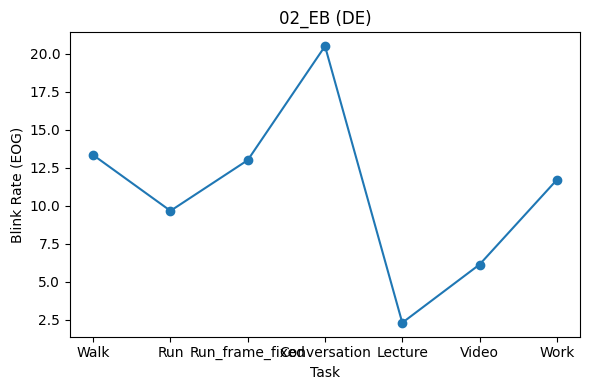

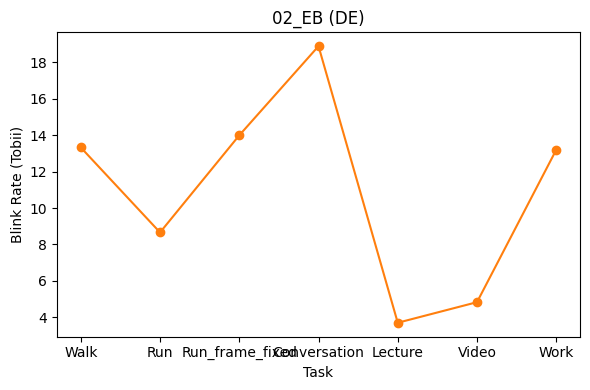

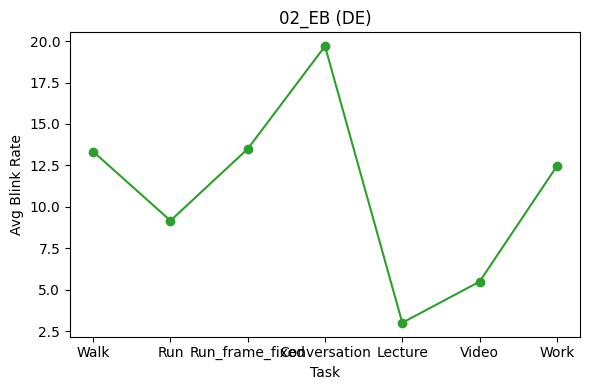

In [44]:
plot_one_participant(participant="02_EB")

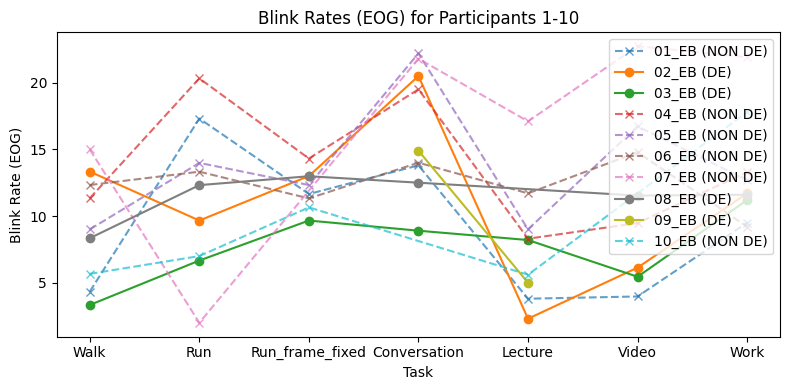

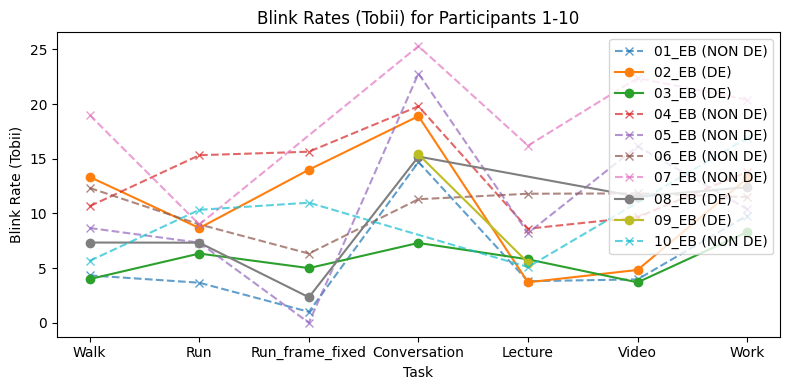

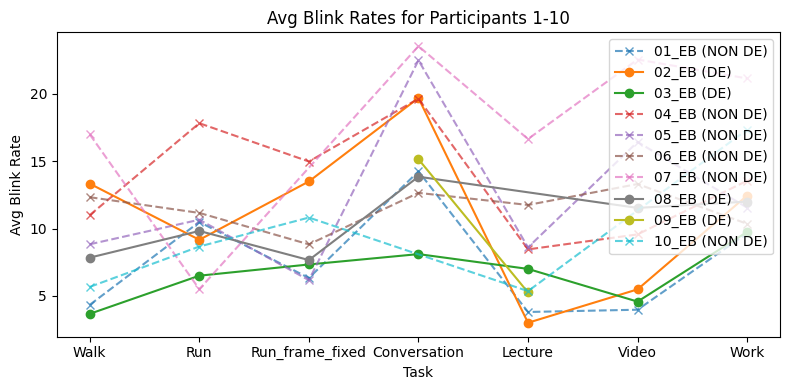

In [45]:
plot_range(range_tuple=(1,10))

C:\Users\yuz\AppData\Local\Temp\ipykernel_32696\2639755731.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df.groupby('Task').agg({


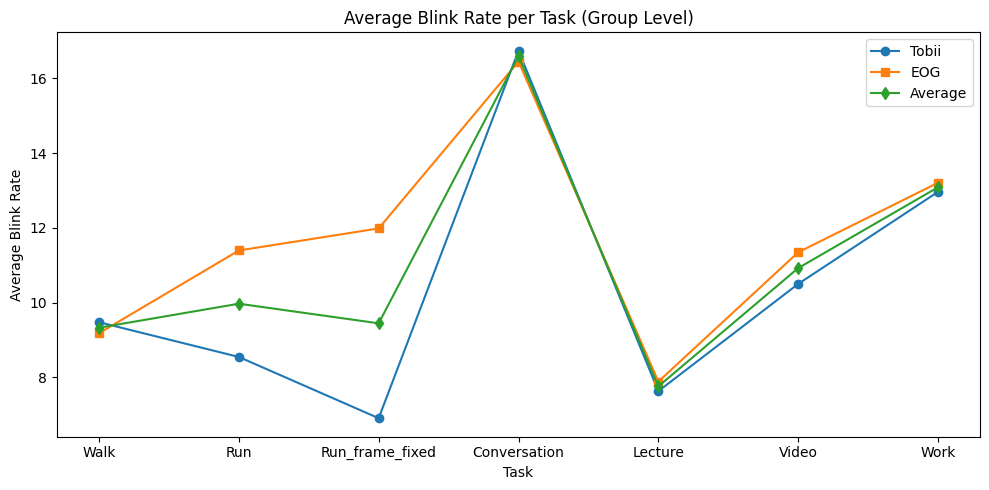

In [46]:
plot_group_average(df)


In [47]:
#Extrack data by seperated task
if 'Task' not in df.columns and 'Task_ID' in df.columns:
    df['Task'] = df['Task_ID'].str.extract(r'_(\w+)$')

if 'Participant' not in df_part.columns and 'numéro' in df_part.columns:
    df_part['Participant'] = df_part['numéro'].apply(lambda n: f"{int(n):02d}_EB")

exclude_tasks = ['Run', 'Run_frame_fixed','Conversation']

global_avg = (
    df.groupby('Participant')
    .agg({
        'Blink Rate (EOG)': 'mean',
        'Blink Rate (Tobii)': 'mean'
    })
    .rename(columns={
        'Blink Rate (EOG)': 'Global Mean Blink Rate (EOG)',
        'Blink Rate (Tobii)': 'Global Mean Blink Rate (Tobii)'
    })
    .reset_index()
)

global_avg['Global Mean Avg Blink Rate'] = global_avg[
    ['Global Mean Blink Rate (EOG)', 'Global Mean Blink Rate (Tobii)']
].mean(axis=1)

df_excluded = df[~df['Task'].isin(exclude_tasks)]
excluded_avg = (
    df_excluded.groupby('Participant')
    .agg({
        'Blink Rate (EOG)': 'mean',
        'Blink Rate (Tobii)': 'mean'
    })
    .rename(columns={
        'Blink Rate (EOG)': 'Excluded Mean Blink Rate (EOG)',
        'Blink Rate (Tobii)': 'Excluded Mean Blink Rate (Tobii)'
    })
    .reset_index()
)
excluded_avg['Excluded Mean Avg Blink Rate'] = excluded_avg[
    ['Excluded Mean Blink Rate (EOG)', 'Excluded Mean Blink Rate (Tobii)']
].mean(axis=1)

# 4. Merge together
df_summary = pd.merge(global_avg, excluded_avg, on='Participant', how='left')

# 5. Merge DE/OSDI 
if 'Participant' not in df_part.columns:
    df_part['Participant'] = df_part['numéro'].apply(lambda n: f"{int(n):02d}_EB")
df_summary = pd.merge(df_summary, df_part[['Participant', 'OSDI-6', 'DE?']], on='Participant', how='left')

# 6. Save 
output_path = r"C:/Users/yuz/Documents/Test_LOOK/blink_rate_by_participant.xlsx"
df_summary.to_excel(output_path, index=False)
print(f"Saved summary to {output_path}")


Saved summary to C:/Users/yuz/Documents/Test_LOOK/blink_rate_by_participant.xlsx


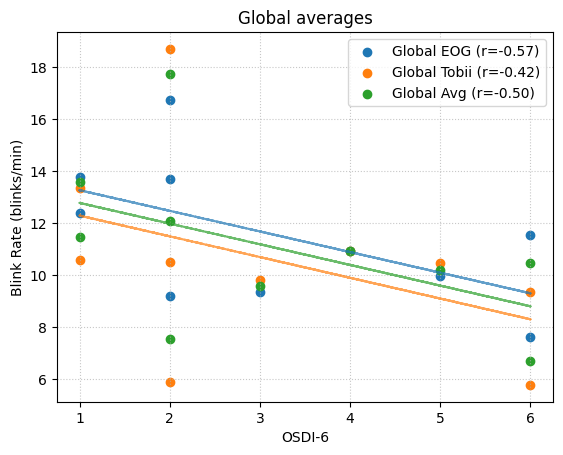

In [48]:
#Make linear regression
# --- 1. Load your summary (adjust path if needed) ---
summary_path = r"C:/Users/yuz/Documents/Test_LOOK/blink_rate_by_participant.xlsx"
df = pd.read_excel(summary_path)

# --- 2. Prepare columns for global/excluded methods ---
global_methods = [
    ('Global Mean Blink Rate (EOG)', 'tab:blue', 'Global EOG'),
    ('Global Mean Blink Rate (Tobii)', 'tab:orange', 'Global Tobii'),
    ('Global Mean Avg Blink Rate', 'tab:green', 'Global Avg'),
]
excluded_methods = [
    ('Excluded Mean Blink Rate (EOG)', 'tab:purple', 'Excluded EOG'),
    ('Excluded Mean Blink Rate (Tobii)', 'tab:pink', 'Excluded Tobii'),
    ('Excluded Mean Avg Blink Rate', 'tab:brown', 'Excluded Avg'),
]

# --------- Global averages plot ----------

for col, color, label in global_methods:
    x = df['OSDI-6'].values
    y = df[col].values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_masked = x[mask]
    y_masked = y[mask]
    slope, intercept, r_value, p_value, std_err = linregress(x_masked, y_masked)
    line = slope * x_masked + intercept
    plt.scatter(x_masked, y_masked, color=color, label=f'{label} (r={r_value:.2f})')
    plt.plot(x_masked, line, color=color, linestyle='--', alpha=0.7)   # <--- dashed
plt.xlabel('OSDI-6')
plt.ylabel('Blink Rate (blinks/min)')
plt.title('Global averages')
plt.legend()
plt.grid(True, linestyle='dotted', alpha=0.7)
plt.show()


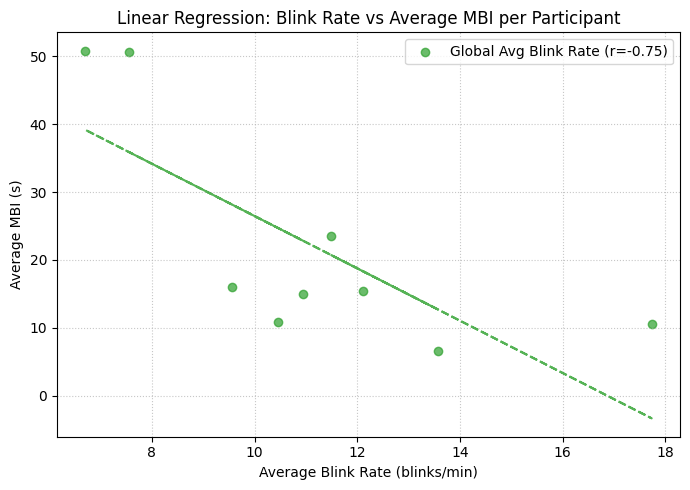

In [49]:
# === LINEAR REGRESSION: Blink Rate (x) vs Average MBI (y) ===

mbi_summary_path = r"C:/Users/yuz/Documents/Test_LOOK/blink_MBI_analysis_summary.xlsx"  
df_mbi = pd.read_excel(mbi_summary_path)

df_mbi['MBI_value'] = df_mbi['MBI Value (Longest Gap, s)'].astype(str).str.replace(',', '.').astype(float)
df_mbi.loc[df_mbi['MBI_value'] < 1, 'MBI_value'] = 60
df_mbi['Participant'] = df_mbi['Task_ID'].str.extract(r'(\d{2}_EB)')
df_avg_mbi = df_mbi.groupby('Participant')['MBI_value'].mean().reset_index()
df_avg_mbi.columns = ['Participant', 'Avg_MBI']


blink_rate_summary_path = r"C:/Users/yuz/Documents/Test_LOOK/blink_rate_by_participant.xlsx"
df_blink = pd.read_excel(blink_rate_summary_path)

df_merge = pd.merge(df_avg_mbi, df_blink, on='Participant', how='inner')


plt.figure(figsize=(7, 5))
for col, color, label in [
    ('Global Mean Avg Blink Rate', 'tab:green', 'Global Avg Blink Rate')
]:
    x = df_merge[col]
    y = df_merge['Avg_MBI']
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        continue  
    slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
    plt.scatter(x[mask], y[mask], color=color, alpha=0.7, label=f'{label} (r={r_value:.2f})')
    plt.plot(x[mask], slope * x[mask] + intercept, color=color, linestyle='--', alpha=0.8)

plt.xlabel('Average Blink Rate (blinks/min)')
plt.ylabel('Average MBI (s)')
plt.title('Linear Regression: Blink Rate vs Average MBI per Participant')
plt.grid(True, linestyle='dotted', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



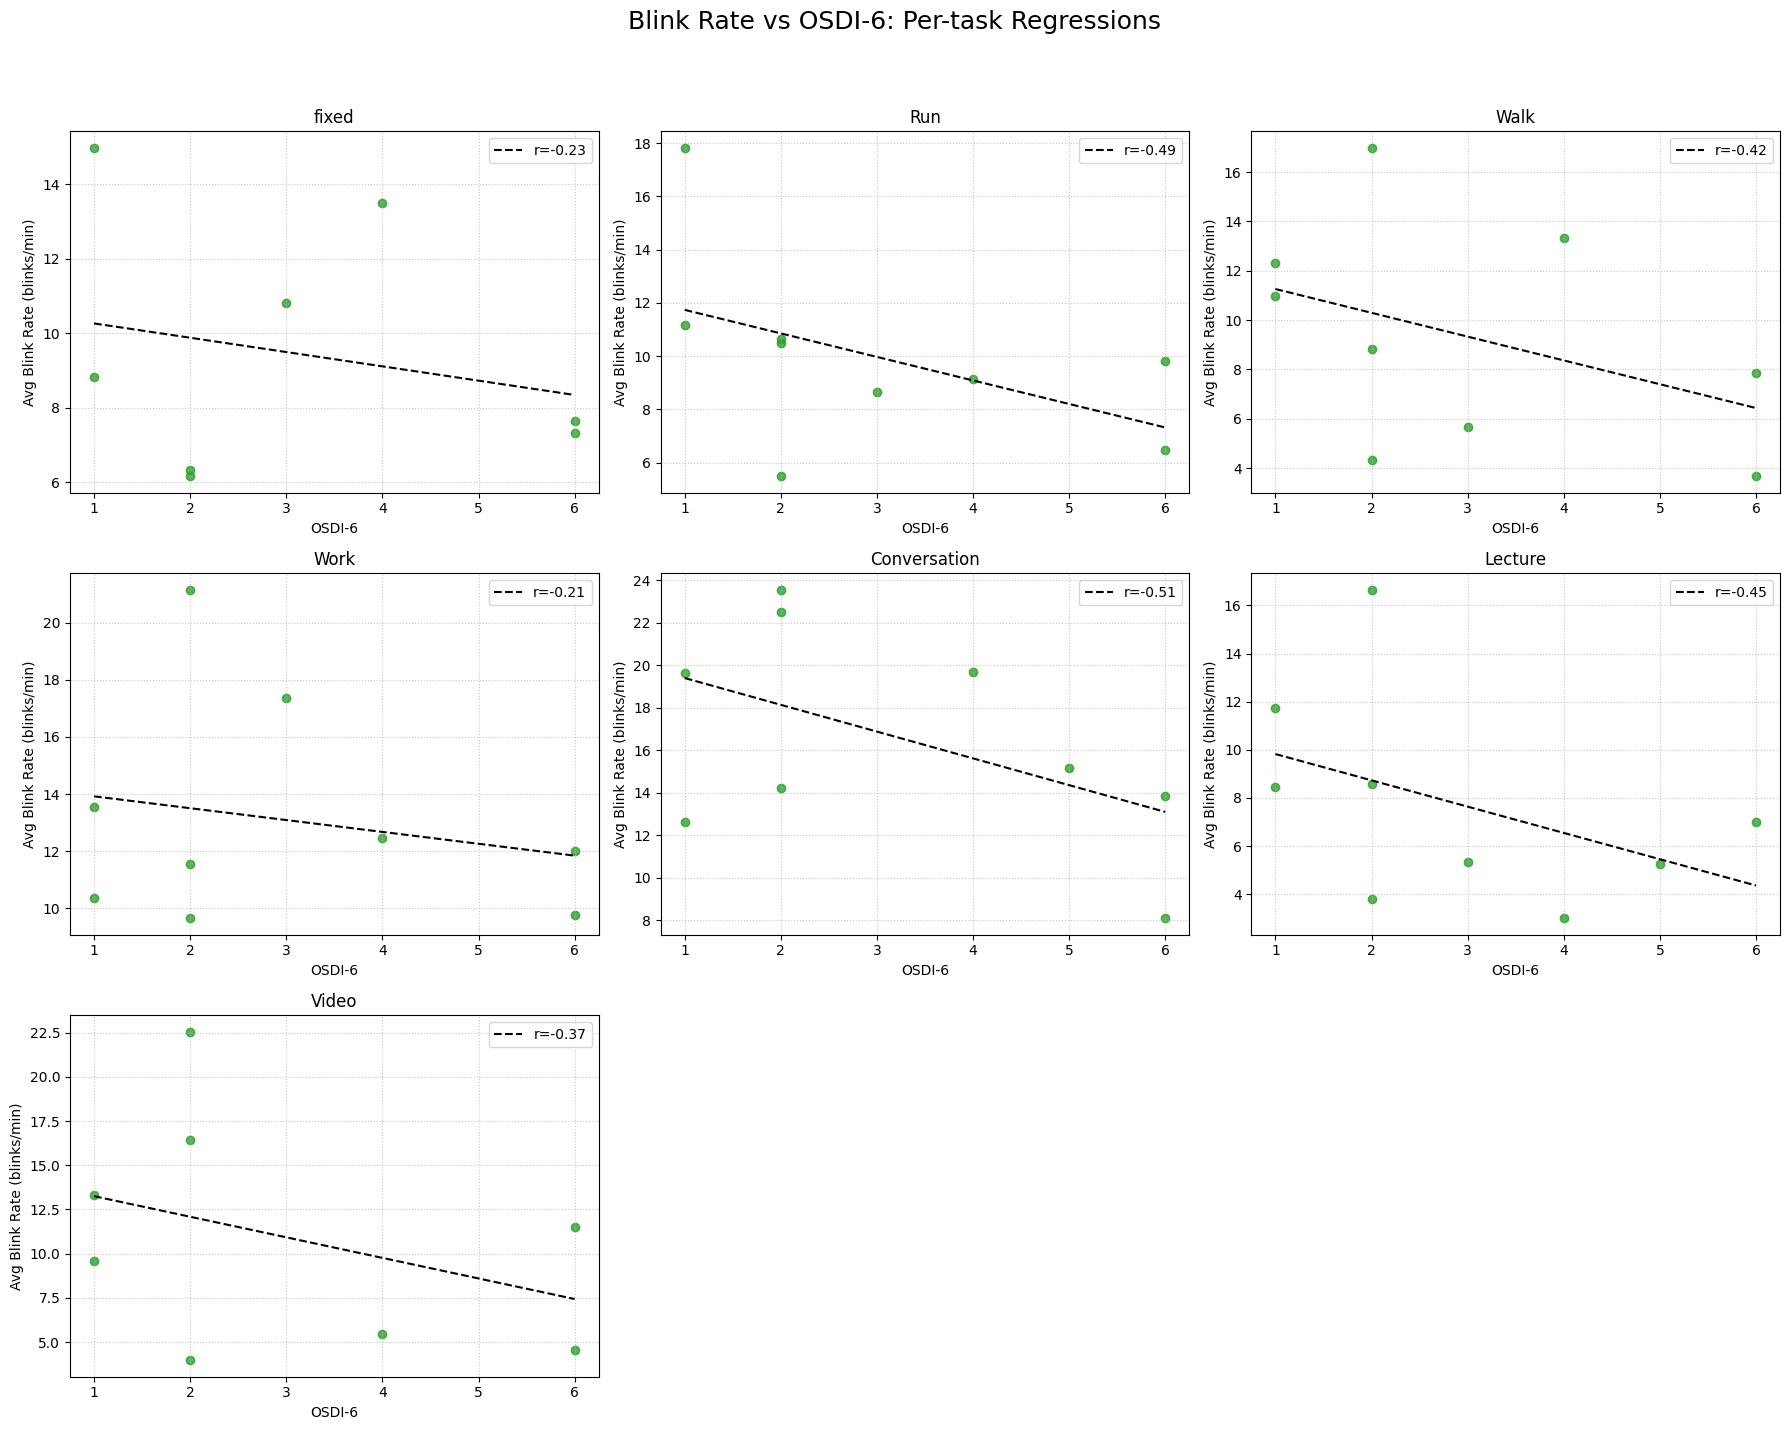

In [50]:
#Seperate regression plot for each task
summary_file = r"C:/Users/yuz/Documents/Test_LOOK/blink_rate_analysis.xlsx"
participant_file = r"C:/Users/yuz/Documents/Test_LOOK/Test LOOK Participant.xlsx"  

df = pd.read_excel(summary_file)
df_part = pd.read_excel(participant_file)
df['Task'] = df['Task_ID'].apply(lambda x: x.split('_')[-1] if isinstance(x, str) and '_' in x else None)
df['Participant'] = df['Task_ID'].apply(lambda x: "_".join(x.split("_")[:2]) if isinstance(x, str) and '_' in x else None)
df['Avg Blink Rate'] = (df['Blink Rate (EOG)'] + df['Blink Rate (Tobii)']) / 2
# 5. Merge DE/OSDI 
if 'Participant' not in df_part.columns:
    df_part['Participant'] = df_part['numéro'].apply(lambda n: f"{int(n):02d}_EB")
df_summary = pd.merge(df_summary, df_part[['Participant', 'OSDI-6', 'DE?']], on='Participant', how='left')


# === Prepare task list ===
tasks = [t for t in df['Task'].dropna().unique() if isinstance(t, str)]
n_tasks = len(tasks)

#subplot
n_cols = 3 
n_rows = math.ceil(n_tasks / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() 

for i, task in enumerate(tasks):
    ax = axes[i]
    df_task = df[df['Task'] == task].copy()
    df_task_merged = pd.merge(
        df_task[['Participant', 'Avg Blink Rate']],
        df_part[['Participant', 'OSDI-6']],
        on='Participant',
        how='left'
    )
    x = df_task_merged['OSDI-6']
    y = df_task_merged['Avg Blink Rate']
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]
    if len(x) > 2:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        ax.scatter(x, y, color='tab:green', alpha=0.8)
        ax.plot(np.sort(x), slope * np.sort(x) + intercept, color='black', linestyle='--', label=f'r={r_value:.2f}')
        ax.set_title(f'{task}')
        ax.set_xlabel('OSDI-6')
        ax.set_ylabel('Avg Blink Rate (blinks/min)')
        ax.legend()
    else:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f'{task}')
        ax.set_xlabel('OSDI-6')
        ax.set_ylabel('Avg Blink Rate (blinks/min)')
    ax.grid(True, linestyle='dotted', alpha=0.7)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Blink Rate vs OSDI-6: Per-task Regressions', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Now one runs for DEQ-5

In [51]:
# Load participant info 
info_df = pd.read_excel("Test LOOK Participant.xlsx")

# Extract participant
if 'Participant' not in info_df.columns and 'numéro' in info_df.columns:
    info_df['Participant'] = info_df['numéro'].apply(lambda n: f"{int(n):02d}_EB")
if 'DEQ-5' not in info_df.columns and 'DEQ_5' in info_df.columns:
    info_df['DEQ-5'] = info_df['DEQ_5']


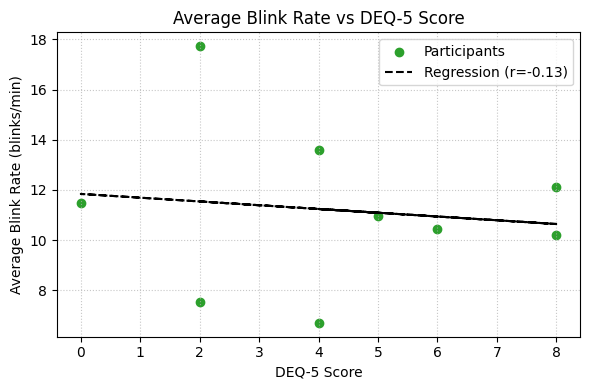

In [52]:
#Regression for DEQ-5 vs BR

df_avg_br = df.groupby('Participant')['Avg Blink Rate'].mean().reset_index()
df_merged_br = pd.merge(df_avg_br, info_df[['Participant', 'DEQ-5']], on='Participant', how='left')

x = df_merged_br['DEQ-5']
y = df_merged_br['Avg Blink Rate']
mask = x.notna() & y.notna()
x = x[mask]
y = y[mask]

if len(x) > 2:
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color='tab:green', label='Participants')
    plt.plot(x, slope * x + intercept, color='black', linestyle='--', label=f'Regression (r={r_value:.2f})')
    plt.xlabel('DEQ-5 Score')
    plt.ylabel('Average Blink Rate (blinks/min)')
    plt.title('Average Blink Rate vs DEQ-5 Score')
    plt.grid(True, linestyle='dotted', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for regression plot (Average Blink Rate vs DEQ-5).")


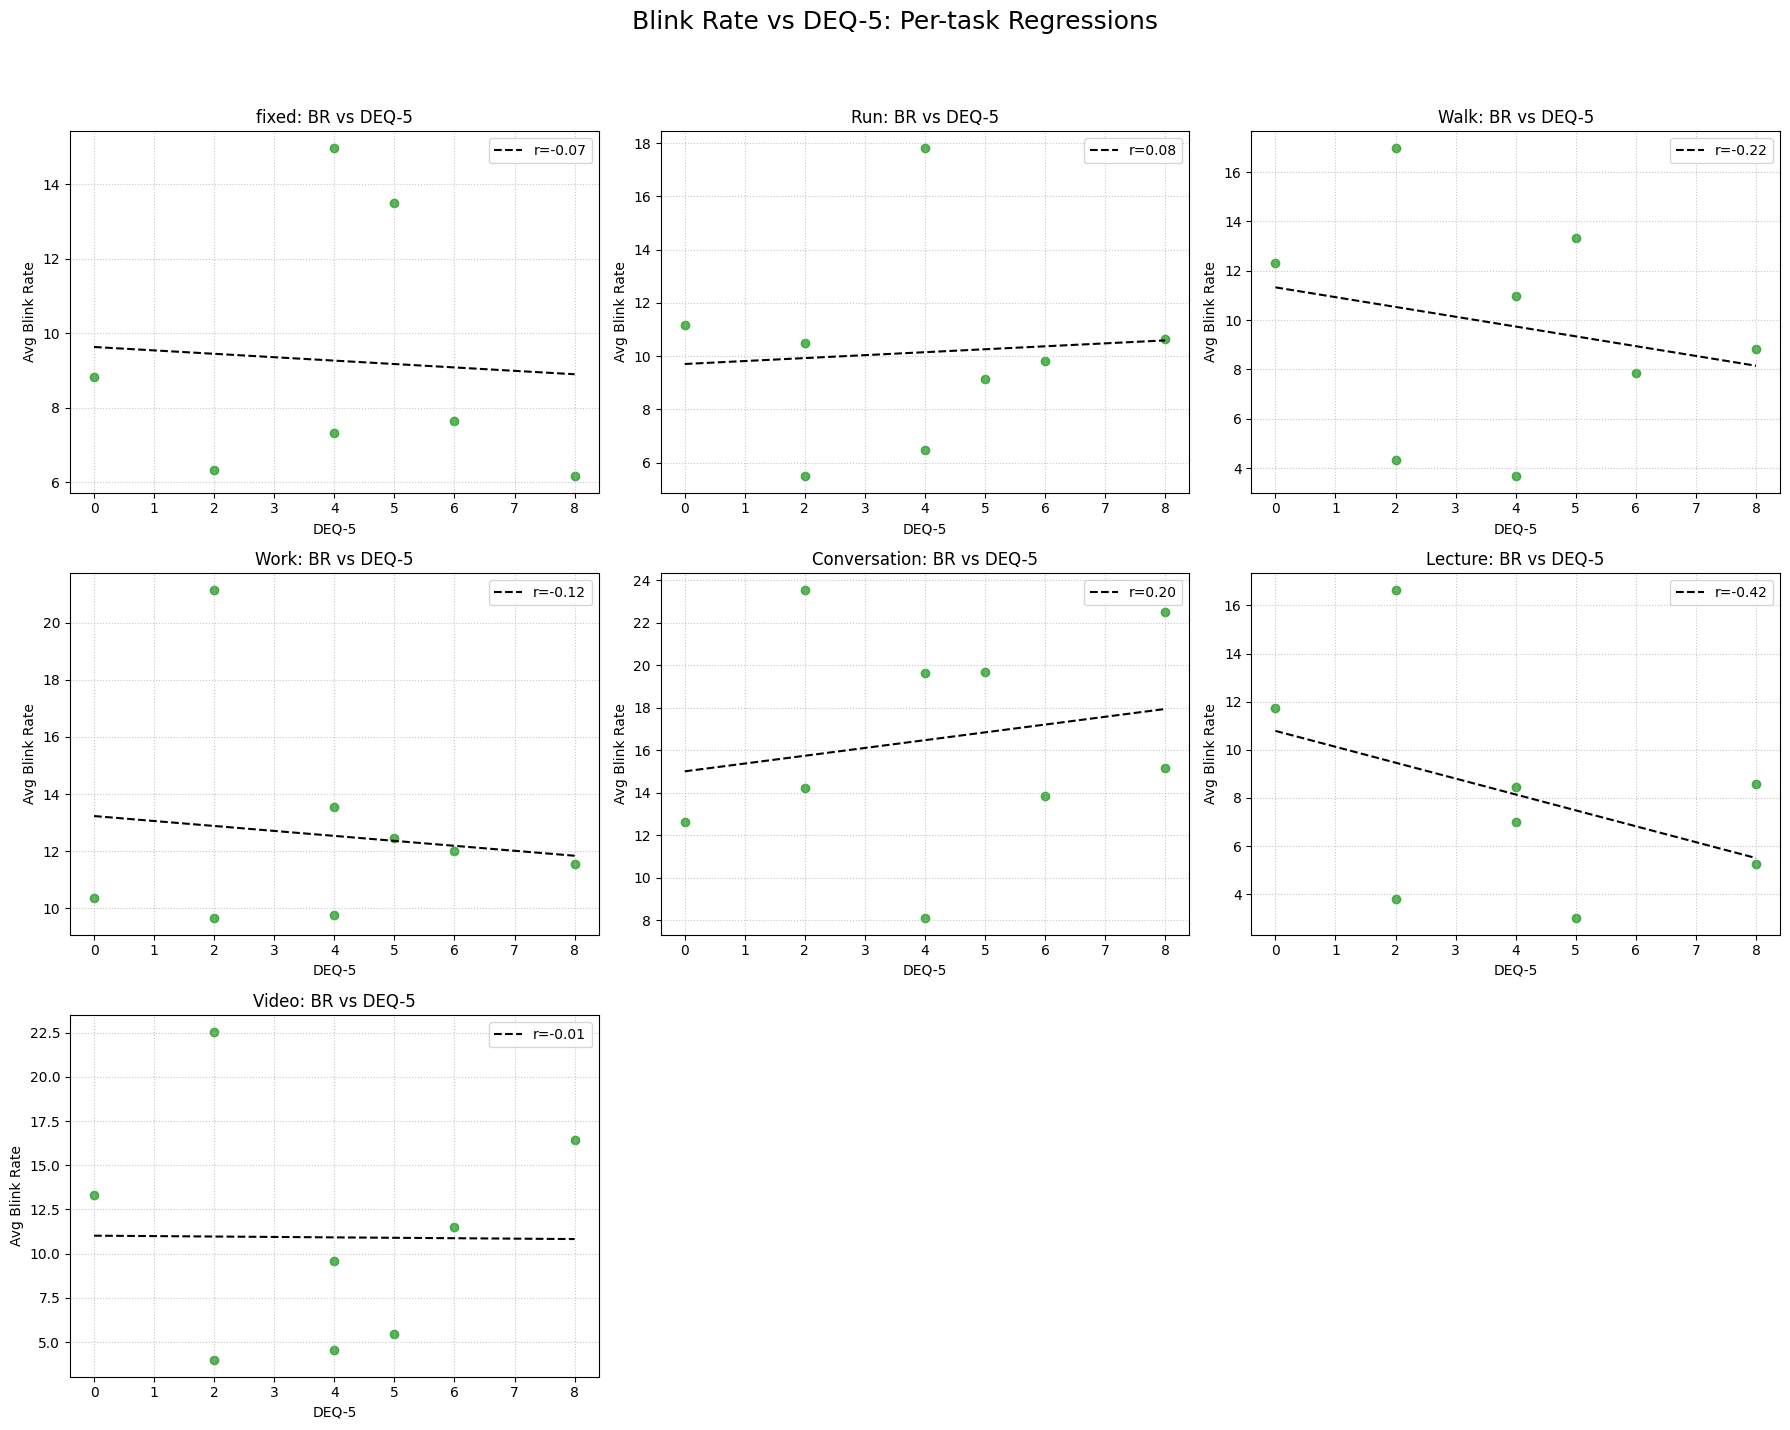

In [53]:
#Regression for DEQ-5 and BR for each task
task_list = [t for t in df['Task'].dropna().unique() if isinstance(t, str)]
n_tasks = len(task_list)
n_cols = 3
n_rows = math.ceil(n_tasks / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, task in enumerate(task_list):
    ax = axes[i]
    df_task = df[df['Task'] == task].copy()
    df_task_merged = pd.merge(df_task[['Participant', 'Avg Blink Rate']], info_df[['Participant', 'DEQ-5']], on='Participant', how='left')
    x = df_task_merged['DEQ-5']
    y = df_task_merged['Avg Blink Rate']
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]
    if len(x) > 2:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        ax.scatter(x, y, color='tab:green', alpha=0.8)
        ax.plot(np.sort(x), slope * np.sort(x) + intercept, color='black', linestyle='--', label=f'r={r_value:.2f}')
        ax.set_title(f'{task}: BR vs DEQ-5')
        ax.set_xlabel('DEQ-5')
        ax.set_ylabel('Avg Blink Rate')
        ax.legend()
    else:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f'{task}: BR vs DEQ-5')
        ax.set_xlabel('DEQ-5')
        ax.set_ylabel('Avg Blink Rate')
    ax.grid(True, linestyle='dotted', alpha=0.7)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Blink Rate vs DEQ-5: Per-task Regressions', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Correlation bewteen OSDI and DEQ

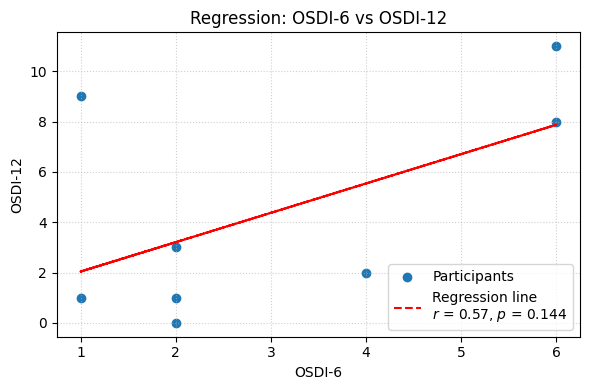


OSDI-6 vs OSDI-12 regression results:
  Slope: 1.167
  Intercept: 0.875
  R-value: 0.565
  P-value: 0.144
  Std Err: 0.695


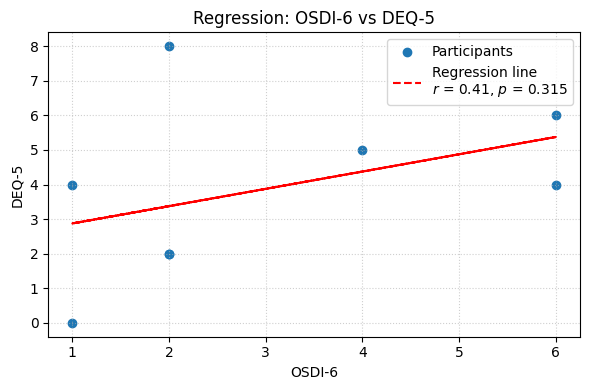


OSDI-6 vs DEQ-5 regression results:
  Slope: 0.500
  Intercept: 2.375
  R-value: 0.409
  P-value: 0.315
  Std Err: 0.456


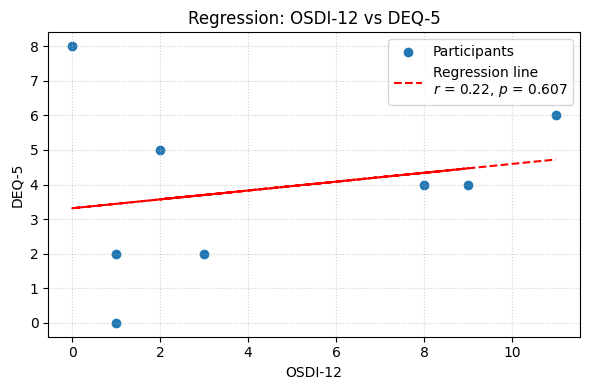


OSDI-12 vs DEQ-5 regression results:
  Slope: 0.128
  Intercept: 3.315
  R-value: 0.216
  P-value: 0.607
  Std Err: 0.236


In [54]:
#Regression between different blink parameter
if 'DEQ-5' not in df_part.columns and 'DEQ_5' in df_part.columns:
    df_part['DEQ-5'] = df_part['DEQ_5']


variables = ['OSDI-6', 'OSDI-12', 'DEQ-5']


df_scores = df_part[variables].dropna()

for i, var_x in enumerate(variables):
    for j, var_y in enumerate(variables):
        if i < j:
            x = df_scores[var_x]
            y = df_scores[var_y]
            slope, intercept, r_value, p_value, std_err = linregress(x, y)

            plt.figure(figsize=(6, 4))
            plt.scatter(x, y, color='tab:blue', label='Participants')
            plt.plot(x, slope * x + intercept, color='red', linestyle='--',
                     label=f'Regression line\n$r$ = {r_value:.2f}, $p$ = {p_value:.3f}')
            plt.xlabel(var_x)
            plt.ylabel(var_y)
            plt.title(f'Regression: {var_x} vs {var_y}')
            plt.grid(True, linestyle='dotted', alpha=0.6)
            plt.legend()
            plt.tight_layout()
            plt.show()

            print(f"\n{var_x} vs {var_y} regression results:")
            print(f"  Slope: {slope:.3f}")
            print(f"  Intercept: {intercept:.3f}")
            print(f"  R-value: {r_value:.3f}")
            print(f"  P-value: {p_value:.3g}")
            print(f"  Std Err: {std_err:.3f}")

regression methods comparaison

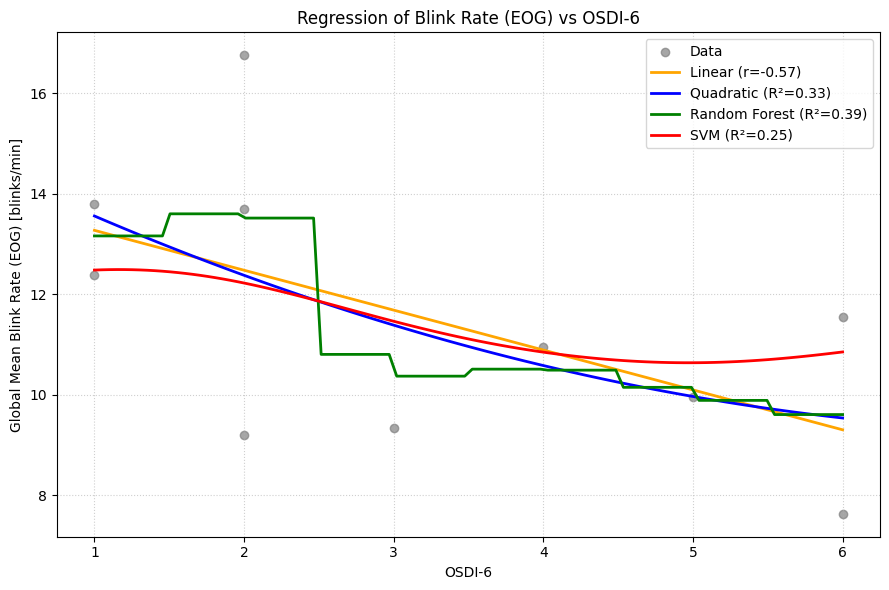

In [55]:
summary_path = r"C:/Users/yuz/Documents/Test_LOOK/blink_rate_by_participant.xlsx"
df = pd.read_excel(summary_path)

X = df[['OSDI-6']].values
y = df['Global Mean Blink Rate (EOG)'].values
mask = ~np.isnan(X[:,0]) & ~np.isnan(y)
X = X[mask]
y = y[mask]
x_flat = X.flatten()

slope, intercept, r_value, p_value, std_err = linregress(x_flat, y)
y_lin = slope * x_flat + intercept

X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_lin_plot = slope * X_plot.flatten() + intercept

# --- Quadratic regression (sklearn) ---
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
X_poly_plot = poly.transform(X_plot)
quad_model = LinearRegression().fit(X_poly, y)
y_quad_plot = quad_model.predict(X_poly_plot)
y_quad_pred = quad_model.predict(X_poly)
quad_r2 = r2_score(y, y_quad_pred)

# --- Random Forest regression ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_rf_plot = rf_model.predict(X_plot)
y_rf_pred = rf_model.predict(X)
rf_r2 = r2_score(y, y_rf_pred)

# --- SVM regression ---
svm_model = SVR(kernel='rbf')
svm_model.fit(X, y)
y_svm_plot = svm_model.predict(X_plot)
y_svm_pred = svm_model.predict(X)
svm_r2 = r2_score(y, y_svm_pred)

# --- Plot everything ---
plt.figure(figsize=(9, 6))
plt.scatter(x_flat, y, label='Data', color='gray', alpha=0.7)
plt.plot(X_plot, y_lin_plot, label=f'Linear (r={r_value:.2f})', color='orange', linewidth=2)
plt.plot(X_plot, y_quad_plot, label=f'Quadratic (R²={quad_r2:.2f})', color='blue', linewidth=2)
plt.plot(X_plot, y_rf_plot, label=f'Random Forest (R²={rf_r2:.2f})', color='green', linewidth=2)
plt.plot(X_plot, y_svm_plot, label=f'SVM (R²={svm_r2:.2f})', color='red', linewidth=2)

plt.xlabel('OSDI-6')
plt.ylabel('Global Mean Blink Rate (EOG) [blinks/min]')
plt.title('Regression of Blink Rate (EOG) vs OSDI-6')
plt.legend()
plt.grid(True, linestyle='dotted', alpha=0.6)
plt.tight_layout()
plt.show()
